### IMPORT THE LIBRARIES

In [1]:
import os
import shutil
import cv2
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.models import load_model
from keras.optimizers import *

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
#After importing the Kaggle.json, we will be able to directly use the kaggle database
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
import kaggle
!kaggle competitions list -s plant

ref                             deadline             category    reward  teamCount  userHasEntered  
------------------------------  -------------------  ----------  ------  ---------  --------------  
plant-seedlings-classification  2018-03-12 23:59:00  Playground   Kudos        834            True  


In [6]:
!kaggle competitions download -c plant-seedlings-classification

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 4.40MB/s]
 94% 81.0M/86.0M [00:03<00:00, 19.7MB/s]
100% 86.0M/86.0M [00:03<00:00, 23.6MB/s]
100% 1.59G/1.60G [00:54<00:00, 29.4MB/s]
100% 1.60G/1.60G [00:54<00:00, 31.7MB/s]


In [0]:
# !mkdir Plant_Seedlings
# !mv train.zip Plant_Seedlings/
# !mv test.zip Plant_Seedlings/
!mv sample_submission.csv.zip Plant_Seedlings/

In [0]:
#Unzipping the imported data base files
import os
import zipfile

train_zip = '/content/Plant_Seedlings/train.zip'
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall('/content/Plant_Seedlings/')
zip_ref.close()

test_zip = '/content/Plant_Seedlings/test.zip'
zip_ref = zipfile.ZipFile(test_zip, 'r')
zip_ref.extractall('/content/Plant_Seedlings/')
zip_ref.close()

The given dataset is not divided into training and validation. So we would have to divide pur dataset into training and validation. Once that is done, we can provide the respective paths to our training and validation directory.

In [0]:
from os import makedirs
from os import listdir
from shutil import copyfile
from shutil import move

dataset_home = '/content/Plant_Seedlings/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

### TRANSFER LEARNING

In [0]:
#define training and validation paths
train_data_dir = "/content/Plant_Seedlings/train"
validation_data_dir = "/content/Plant_Seedlings/test"

In [15]:
#define image data generator
IMG_SHAPE = (224, 224)
CLASSES = 12
BATCH_SIZE = 10

train_datagen = ImageDataGenerator(rescale = 1/255.)

valid_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = IMG_SHAPE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

validation_generator = valid_datagen.flow_from_directory(validation_data_dir,
                                                         target_size = IMG_SHAPE,
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'categorical',
                                                         shuffle = False)

Found 4750 images belonging to 12 classes.
Found 0 images belonging to 0 classes.


### VISULALIZE THE DATA

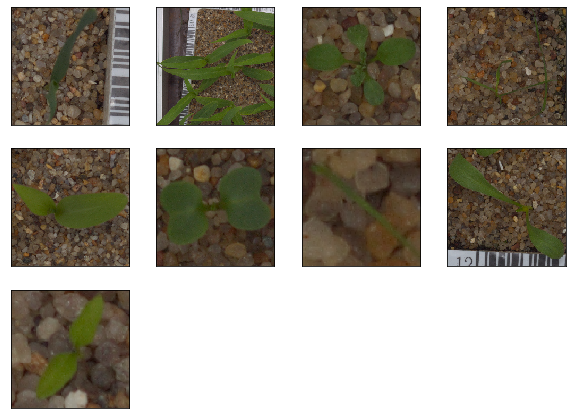

In [16]:
fig = plt.figure(figsize = (10, 10))

for i in range(9):
    ax = fig.add_subplot(4, 4, i + 1, xticks = [], yticks = [])
    #ax.set_title(["NORMAL" if next(train_with_da)[1][i]==0 else "PNEUMONIA"])
    #ax.set_title(next(train_datagen)[1][i])
    ax.imshow(next(train_generator)[0][i])
plt.show()

In [17]:
#here we will use VGG19 pre-trained on imagenet dataset
base_model = VGG19(weights = "imagenet", include_top = False)
base_model.summary()





80142336/80134624 [==============================] - 7s 0us/step






Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________________________

In [18]:
x = base_model.output #take the output of the last VGG19 layer
x = GlobalAveragePooling2D()(x) 
predictions = Dense(CLASSES, activation = "softmax")(x) #output classification layer
model = Model(inputs = base_model.input, outputs = predictions)


#out of the total 22 layers, we will freeze the first 15 layers and will fine-tune the next 7 layers
for layers in base_model.layers[:15]:
    layers.trainable = False
for layers in base_model.layers[15:]:
    layers.trainable = True
    
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [19]:
#compile the model
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.0001), metrics = ['accuracy'])

In [0]:
steps_per_epochs = 3000//10
validation_steps = 600//10

In [21]:
history = model.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = steps_per_epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_steps,
                              verbose = 2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
 - 66s - loss: 1.7518 - acc: 0.3907
Epoch 2/20
 - 62s - loss: 0.9335 - acc: 0.6663
Epoch 3/20
 - 62s - loss: 0.6657 - acc: 0.7673
Epoch 4/20
 - 61s - loss: 0.4900 - acc: 0.8290
Epoch 5/20
 - 61s - loss: 0.4428 - acc: 0.8437
Epoch 6/20
 - 61s - loss: 0.3660 - acc: 0.8697
Epoch 7/20
 - 61s - loss: 0.3285 - acc: 0.8800
Epoch 8/20
 - 61s - loss: 0.3052 - acc: 0.8943
Epoch 9/20
 - 61s - loss: 0.2246 - acc: 0.9220
Epoch 10/20
 - 61s - loss: 0.1955 - acc: 0.9273
Epoch 11/20
 - 61s - loss: 0.2552 - acc: 0.9063
Epoch 12/20
 - 61s - loss: 0.2161 - acc: 0.9280
Epoch 13/20
 - 61s - loss: 0.1760 - acc: 0.9433
Epoch 14/20
 - 61s - loss: 0.1352 - acc: 0.9530
Epoch 15/20
 - 61s - loss: 0.2005 - acc: 0.9303
Epoch 16/20
 - 61s - loss: 0.1045 - acc: 0.9670
Epoch 17/20
 - 61s - loss: 0.1178 - acc: 0.9617
Epoch 18/20
 - 61s - loss: 0.0938 - acc: 0.9710
Epoch 19/20
 - 61s - loss: 0.1669 - acc: 0.9463
E

### PLOT THE LOSS AND ACCURACY CURVES

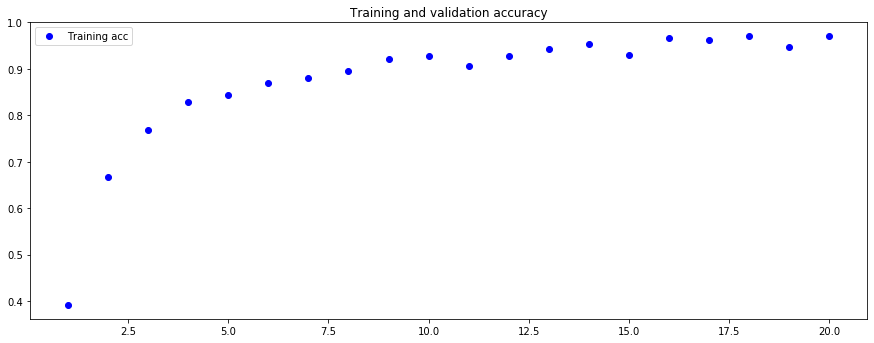

<Figure size 432x288 with 0 Axes>

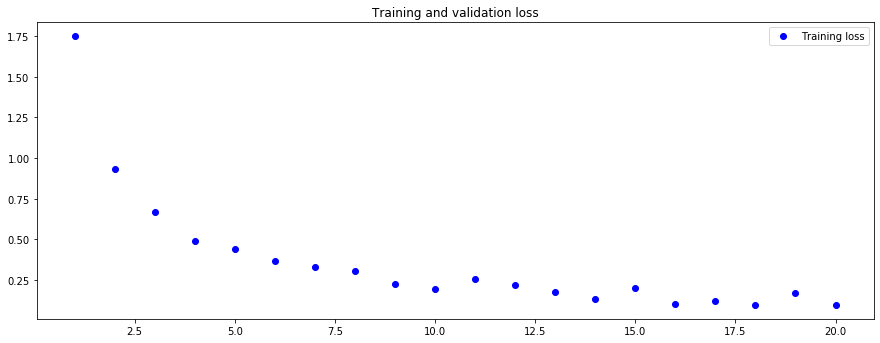

In [23]:
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize = (15,12))
plt.subplot(211)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
#plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.figure(figsize = (15,12))
plt.subplot(212)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
#plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### VALIDATE ON TEST DATA

In [24]:
evaluate = model.evaluate_generator(validation_generator)
print(f"The loss is : {evaluate[0]}")
print()
print(f"The validation accuracy is : {evaluate[1]}")

UnboundLocalError: ignored

### SAVE THE MODEL

In [0]:
#save the model weights
model.save_weights("vgg_weights.h5")

In [0]:
model.save('vgg_entire_model.h5')  # creates a HDF5 file 'my_model.h5'

### LOAD THE MODEL

In [0]:
# returns a compiled model
# identical to the previous one
loaded_model = load_model('vgg_entire_model.h5')

In [28]:
train_generator.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

### MAKE PREDICTIONS ON NEW DATA

In [0]:
#map each class value to it's corresponding label
class_to_label = {0: 'Black-grass', 
                  1: 'Charlock', 
                  2: 'Cleavers', 
                  3: 'Common Chickweed', 
                  4: 'Common whea', 
                  5: 'Fat Hen',
                  6: 'Loose Silky-bent',
                  7: 'Maize',
                  8: 'Scentless Mayweed',
                  9: 'Shepherd’s Purse',
                  10: 'Small-flowered Cranesbill',
                  11: 'Sugar beet'}

In [0]:
def make_predictions(IMG_PATH, model):
    """
    IMG_PATH = Path to the image you wanna make predictions on 
    model = The trained / loaded model
    """
    img_path = IMG_PATH
    img = load_img(img_path, target_size = (224, 224))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis = 0)
    img_tensor /= 255
    preds = model.predict(img_tensor, batch_size = 1)
    pred_val = np.argmax(preds)
    plt.imshow(img_tensor.reshape(224, 224, 3))
    plt.title(class_to_label[pred_val])
    plt.axis("off")
    return class_to_label[pred_val]

'Black-grass'

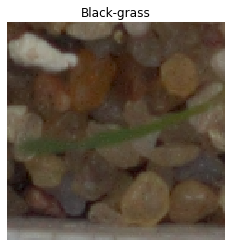

In [0]:
#provide the path to the image that we wanna make predictions on
IMG_PATH = "F:/datasets/Plant Seedlings/Train/Black-grass/3.png"
make_predictions(IMG_PATH, loaded_model)

'Maize'

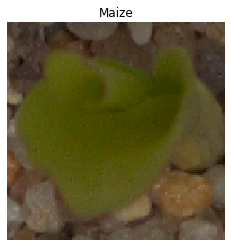

In [0]:
IMG_PATH = "F:/datasets/Plant Seedlings/Train/Maize/5.png"
make_predictions(IMG_PATH, loaded_model)

'Sugar beet'

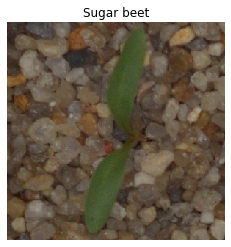

In [0]:
IMG_PATH = "F:/datasets/Plant Seedlings/Train/Sugar beet/5.png"
make_predictions(IMG_PATH, loaded_model)